In [2]:
import sys

from pathlib import Path
ROOT_PATH = Path.cwd().parent

# To access packages and files from root directory
sys.path.insert(1, str(ROOT_PATH))

In [3]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [4]:
FIG_PATH = Path('./figures/2DGP_figures')
FIG_PATH.mkdir(exist_ok=True)

PUBLICATION_PATH = FIG_PATH / 'VGAE_base_print'
PUBLICATION_PATH.mkdir(exist_ok=True)

DATASET_PATH = ROOT_PATH / 'dataset.nosync'
DATASET_PATH.mkdir(exist_ok=True)

In [5]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [6]:
# create grid
n = 25
grid = jnp.arange(0, 1, 1/n)
u, v = jnp.meshgrid(grid, grid)

X = jnp.array([u.flatten(), v.flatten()]).transpose((1, 0))
IMAGE_SHAPE = (n, n)

adj_matrix, _, _, num_regions, _ = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

In [7]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP2DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  adj_matrix: np.ndarray = adj_matrix
  num_regions: int = num_regions
  
@dataclass
class Args:
  batch_size: int = 100
  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 10_000
  eval_frequency: int = 50
  learning_rate: float = 1e-4
  beta: float = 1e-3  # beta-VAE
  
  # Model params
  hidden_gnn_dim: int = 10
  hidden_fc_dim: int = 0
  latent_dim: int = 10
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP2D_ARGS = GP2DArgs()
ARGS = Args()

In [8]:
model_name = (
    f'VGAEL2G_2DGP_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\beta = {ARGS.beta}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    ')'
)

print(model_name)

VGAEL2G_2DGP_lr0.0001_epochs10000_beta0.001_gnn10_fc0_z10


# Dataset: GP priors to be encoded

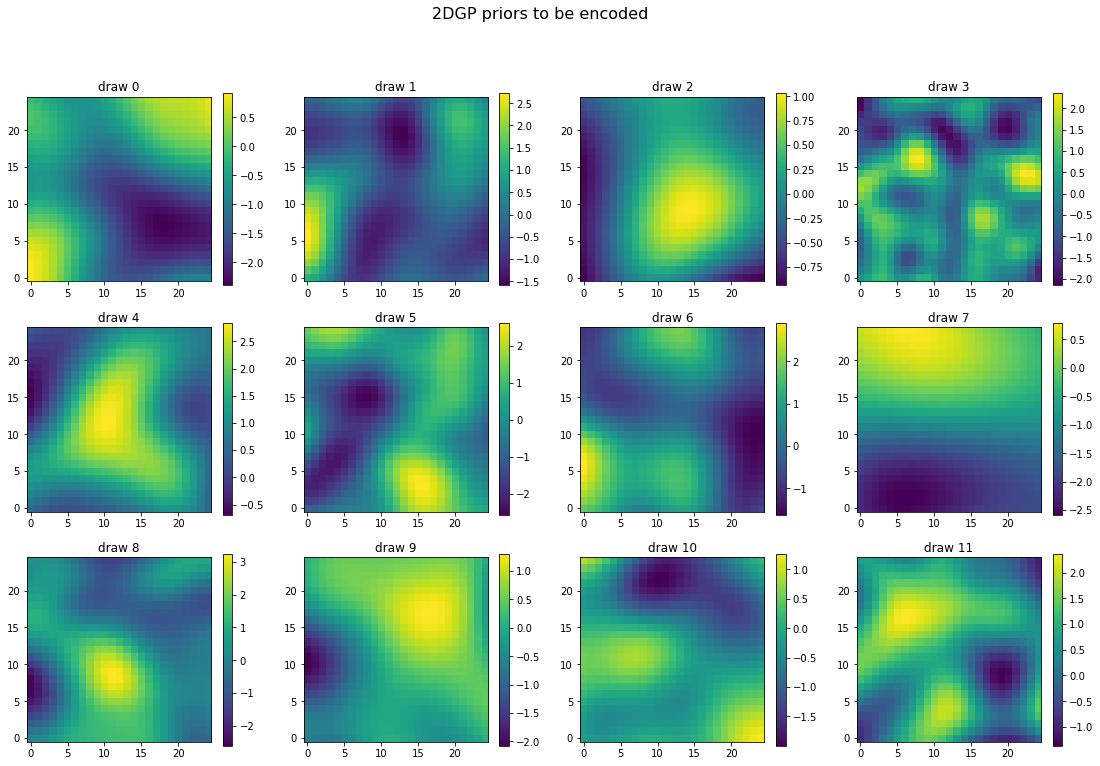

<Figure size 432x288 with 0 Axes>

In [9]:
num_to_plot = 50
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP2D_ARGS.kernel)

gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

plotting.plot_samples(gp_draws, image_shape=IMAGE_SHAPE, title='2DGP priors to be encoded')
plt.tight_layout()
plt.show();

In [10]:
data_filepath = DATASET_PATH / '2DGP_600k_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 600_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP2D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/dataset.nosync/2DGP_600k_train_data.npy


In [11]:
data.shape

(600000, 625)

In [12]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]
print(f'Shape after removing NaNs: {data.shape}')

train_size_limit = 500_000
val_size = 10_000  # + 1000 for the final epoch evaluation and batching

train_data = data[:train_size_limit]
val_data = data[train_size_limit:train_size_limit+val_size]

Shape after removing NaNs: (527214, 625)


In [13]:
batched_train_data = train_data.reshape(-1, ARGS.batch_size, GP2D_ARGS.num_regions)
batched_val_data = val_data.reshape(-1, ARGS.batch_size, GP2D_ARGS.num_regions)
print(batched_train_data.shape)
print(batched_val_data.shape)

(5000, 100, 625)
(100, 100, 625)


In [14]:
BASE_GRAPH = dataset.create_grid_graph(GP2D_ARGS.adj_matrix)

try:
    _ = len(graph_batched_train_data)  # dummy line to check graph_batched_train_data is in local vars
except:
    graph_batched_train_data = []
    graph_batched_val_data = []

    for batch in batched_train_data:
        graph_batch = [BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) for draw in batch]
        graph_batched_train_data.append(jraph.batch(graph_batch))
        
    for batch in batched_val_data:
        graph_batch = [BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) for draw in batch]
        graph_batched_val_data.append(jraph.batch(graph_batch))

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Comment: Removing linear (hidden_fc) before latent hidden layer makes samples even NOISIER

# Building the model

In [15]:
from model import VGAEOutput
import layer

class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
    ):
        super().__init__()
        self._hidden_gnn_dim = hidden_gnn_dim
        self._hidden_fc_dim = hidden_fc_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim
        self._num_nodes = num_nodes
        self._batch_size = batch_size
        self.act = ARGS.act_fn

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean, log_std = encoder(
            graph,
            self._hidden_gnn_dim,
            self._hidden_fc_dim,
            self._latent_dim,
            self._num_nodes,
            self._batch_size,
            self.act,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = decoder(
            z,
            graph,
            self._hidden_fc_dim,
            self._hidden_gnn_dim,
            self._output_dim,
            self._num_nodes,
            self._batch_size,
            self.act
        )

        return VGAEOutput(mean, log_std, output)

def encoder(
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        hidden_fc_dim: int,
        latent_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    x = graph.nodes.reshape(batch_size, num_nodes, hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (batch_size, num_nodes*hidden_gnn_dim)
    
    # No activation
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def decoder(
        z: jnp.ndarray,
        graph: jraph.GraphsTuple,
        hidden_fc_dim: int,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (batch_size, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((batch_size*num_nodes, hidden_gnn_dim))
    # graph = BASE_GRAPH._replace(nodes=z)
    graph = graph._replace(nodes=z)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=True,
    )
    graph = gn(graph)

    return graph

In [16]:
extend_model_params_title = False
    
extension_string = 'add_self_edges = True'

if extend_model_params_title:
    model_params_title = model_params_title[:-1] + ', ' + extension_string

# Training time

In [17]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 batch_size=ARGS.batch_size,
                 num_nodes=GP2D_ARGS.num_regions)(x))

## Training optimizer

In [18]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

### Loss function and update

In [19]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  # log_likelihood = -log_likelihood_loss_fn(outputs.output, graph.nodes)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = (1.0/ARGS.beta)*log_likelihood - kld
  
  return -elbo, kld
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

### Initialize net and optimizer

In [20]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = graph_batched_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [21]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []
train_klds = []
val_klds = []

train_size = len(graph_batched_train_data)
val_size = len(graph_batched_val_data)

eval_counter: int = 0

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = graph_batched_train_data[epoch % train_size]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = graph_batched_val_data[eval_counter % val_size]
    val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
          f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
          # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
    )
      
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_klds.append(train_kld.item())
    val_klds.append(val_kld.item())
    
    eval_counter += 1

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x175b168b0>
16:05:51 STEP: 0; Train loss: 963.646; Validation loss: 1240.159; 
16:05:55 STEP: 50; Train loss: 890.879; Validation loss: 876.287; 
16:05:59 STEP: 100; Train loss: 750.582; Validation loss: 712.980; 
16:06:02 STEP: 150; Train loss: 702.151; Validation loss: 646.639; 
16:06:06 STEP: 200; Train loss: 542.527; Validation loss: 641.613; 
16:06:10 STEP: 250; Train loss: 522.744; Validation loss: 469.017; 
16:06:14 STEP: 300; Train loss: 453.655; Validation loss: 420.097; 
16:06:18 STEP: 350; Train loss: 352.165; Validation loss: 337.992; 
16:06:21 STEP: 400; Train loss: 346.171; Validation loss: 350.930; 
16:06:25 STEP: 450; Train loss: 318.736; Validation loss: 287.762; 
16:06:29 STEP: 500; Train loss: 286.589; Validation loss: 278.457; 
16:06:33 STEP: 550; Train loss: 268.443; Validation loss: 284.829; 
16:06:36 STEP: 600; Train loss: 229.695; Validation loss: 218.666; 
16:06:40 STEP: 650; Train loss: 240.183; Validation loss: 239.910; 

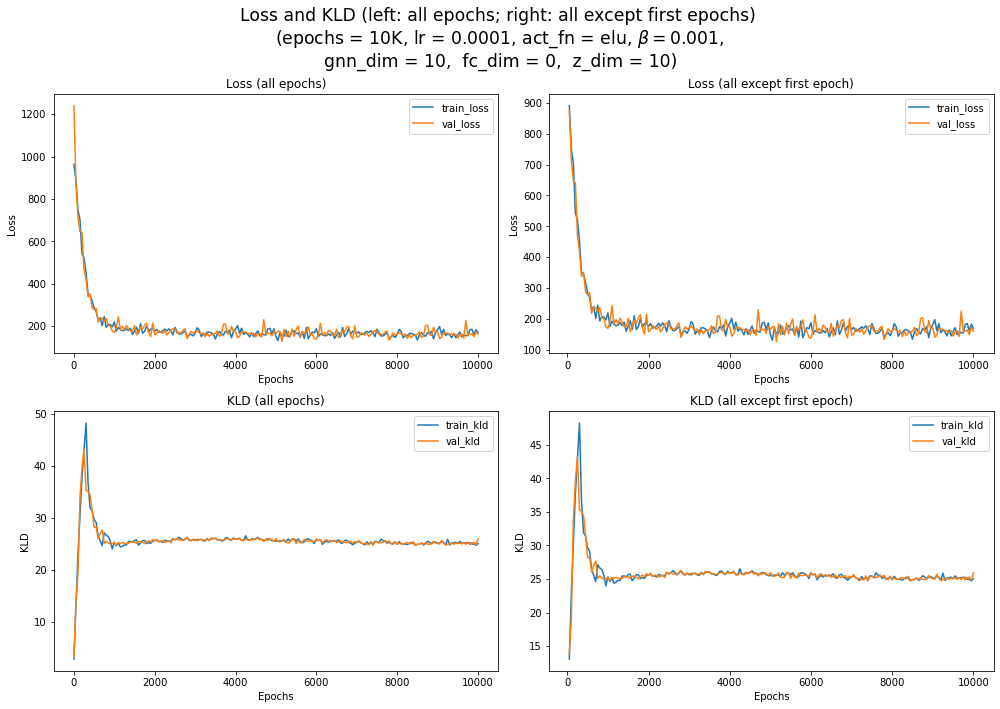

In [22]:
from matplotlib.ticker import MaxNLocator

# Loss plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0, 0].plot(xs, train_losses, label='train_loss')
axes[0, 0].plot(xs, val_losses, label='val_loss')
axes[0, 1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[0, 1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0, 0].set_title('Loss (all epochs)')
axes[0, 1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[0, i].set_ylabel('Loss')
    axes[0, i].set_xlabel('Epochs')
    axes[0, i].legend()
    
# KLD plots
xs = np.arange(len(train_klds))*ARGS.eval_frequency
axes[1, 0].plot(xs, train_klds, label='train_kld')
axes[1, 0].plot(xs, val_klds, label='val_kld')
axes[1, 1].plot(xs[1:], train_klds[1:], label='train_kld')
axes[1, 1].plot(xs[1:], val_klds[1:], label='val_kld')
axes[1, 0].set_title('KLD (all epochs)')
axes[1, 1].set_title('KLD (all except first epoch)')

for i in range(2): 
    axes[1, i].set_ylabel('KLD')
    axes[1, i].set_xlabel('Epochs')
    axes[1, i].legend()

fig.suptitle(f'Loss and KLD (left: all epochs; right: all except first epochs) \n{model_params_title}', fontsize='xx-large')

plt.tight_layout()
plt.show()

loss_kld_path = FIG_PATH / 'loss_kld_figures'
loss_kld_path.mkdir(exist_ok=True)
fig.savefig(loss_kld_path / f'{model_name}.jpg', dpi=300)

In [42]:
MODEL_PATH = Path.cwd() / 'models'
MODEL_PATH.mkdir(exist_ok=True)

SAVE_MODEL = True

model_name = MODEL_PATH / '2DGP_VGAE_base'

if SAVE_MODEL:
    model_name.mkdir(exist_ok=True)
    model.save_params(model_name, params)
    print(f'Saved to path: {model_name}')
else:
    print('Did not save model.')

Saved to path: /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/models/2DGP_VGAE_base


/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


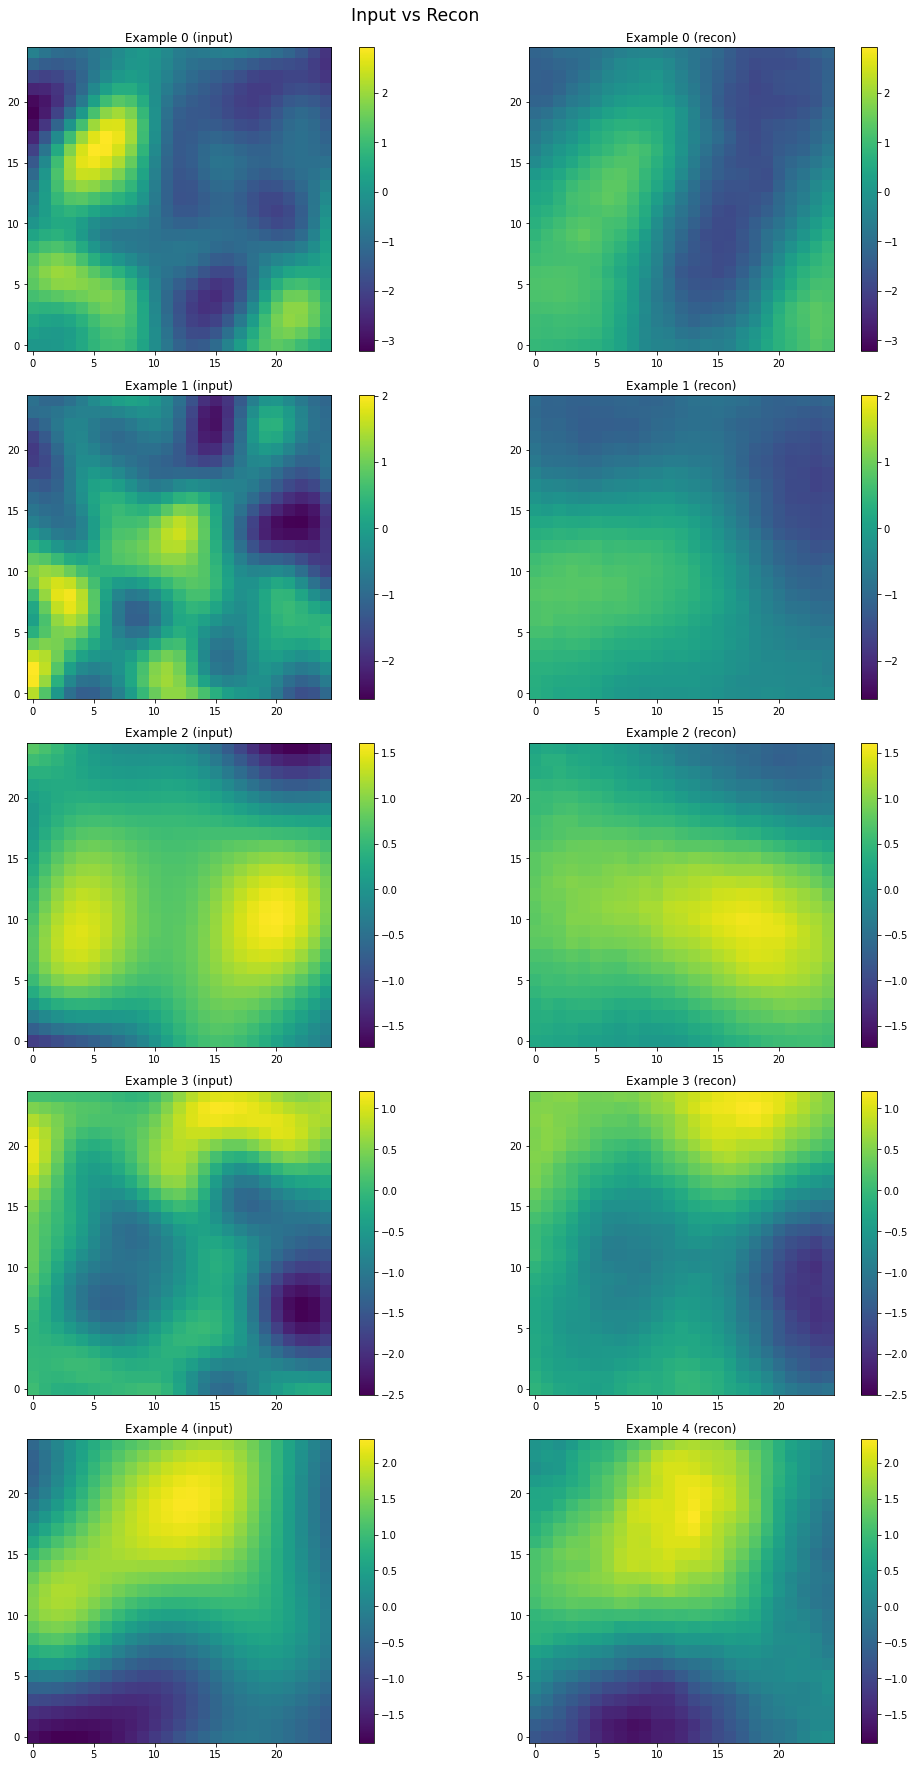

In [23]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

num_to_plot = 5
# fig, axes = plt.subplots(num_to_plot, 2, figsize=(15, 25))

original_data = graph_batched_val_data[0]

outputs = net.apply(params, rng_recon, original_data)
recon_data = outputs.output.nodes
recon_data = jnp.reshape(recon_data, (ARGS.batch_size, GP2D_ARGS.num_regions))

original_images = []
recon_images = []

for i in range(num_to_plot):
    original_image = jnp.ravel(jraph.unbatch(original_data)[i].nodes)
    recon_image = jnp.ravel(recon_data[i])
    
    original_images.append(original_image)
    recon_images.append(recon_image)

fig, ax = plotting.plot_recon_images(
    original_arrays=original_images,
    recon_arrays=recon_images,
    image_shape=IMAGE_SHAPE,
    figsize=(15, 25),
)

fig.suptitle(f'Input vs Recon\n', fontsize='xx-large')

plt.tight_layout()
plt.show()

In [24]:
from functools import partial

decoder_params_keys = [k for k in list(params.keys()) if k.startswith('vgae/decoder')]
decoder_params = {}
for full_key_name in decoder_params_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    decoder_params[key_name] = params[full_key_name]
    
GP2D_ARGS.decoder_params = decoder_params

decoder_net_fn = partial(decoder,
                         graph=BASE_GRAPH,
                         hidden_fc_dim=ARGS.hidden_fc_dim,
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         batch_size=1,
                         num_nodes=GP2D_ARGS.num_regions)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [25]:
def decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP2D_ARGS.decoder_params, z).nodes)
    numpyro.deterministic('f', vgae_out)

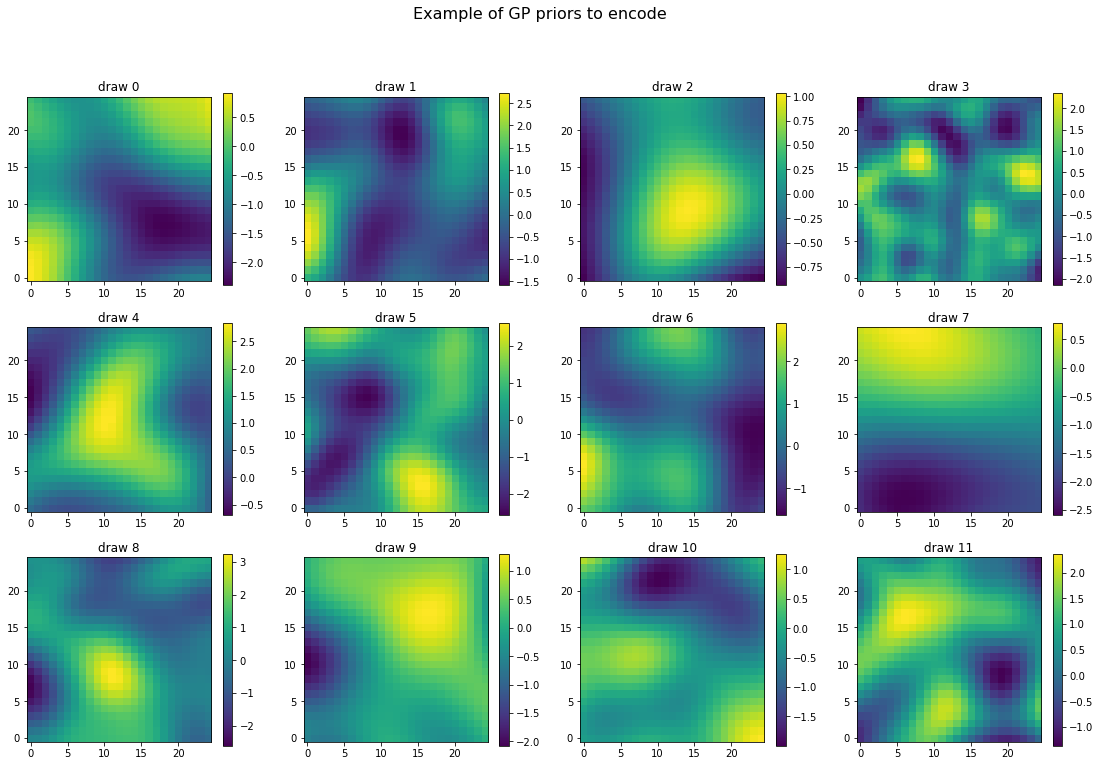

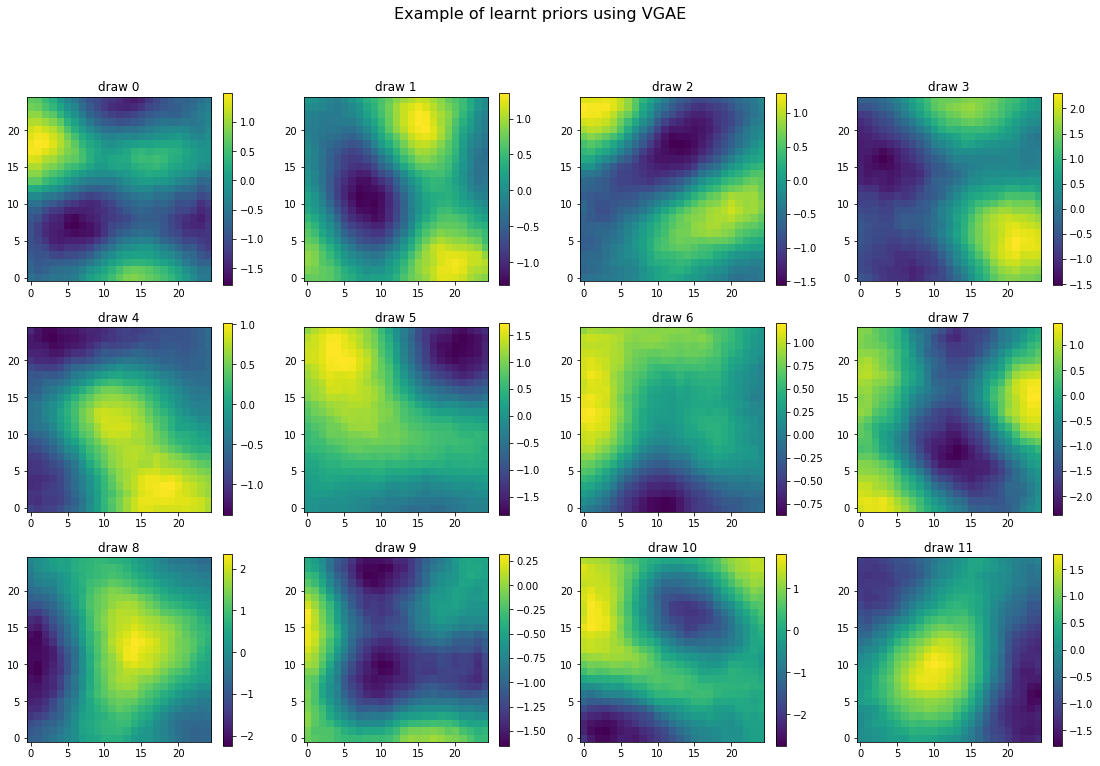

<Figure size 432x288 with 0 Axes>

In [26]:
RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)

vgae_draws = Predictive(decoder_predictive_model, num_samples=15)(vgae_sample_rng)['f']

plotting.plot_samples(gp_draws, image_shape=IMAGE_SHAPE, title='Example of GP priors to encode')
plotting.plot_samples(vgae_draws, image_shape=IMAGE_SHAPE, title='Example of learnt priors using VGAE')

plt.tight_layout()
plt.show()

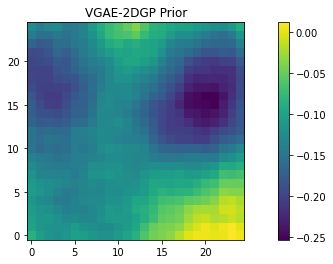

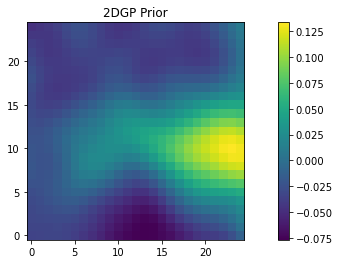

In [27]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP2D_ARGS.kernel)
vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples)(vgae_rng)['f']

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

plotting.plot_images_from_arrays(
    arrays=[mean_vgae],
    titles=['VGAE-2DGP Prior'],
    image_shape=IMAGE_SHAPE,
)
plotting.plot_images_from_arrays(
    arrays=[mean_gp],
    titles=['2DGP Prior'],
    image_shape=IMAGE_SHAPE,
);

In [28]:
# assert False

# Inference on Observed Data

In [29]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(decoder_params, z).nodes)
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.LogNormal(0.0, 0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [30]:
RNG_KEY = jax.random.PRNGKey(1)  # promising!
# RNG_KEY = jax.random.PRNGKey(4)
RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
gp_draw = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
    gp_rng, x=X, gp_kernel=GP2D_ARGS.kernel, noise=True, kernel_length=0.27,
)
y_truth = gp_draw['f'].T
y_observed = gp_draw['y'].T

In [31]:
# Percentage of observed locations
pct_obs_locations = np.array([0.01, 0.02, 0.05])

num_obs_locations = np.round(pct_obs_locations * GP2D_ARGS.num_regions)
num_obs_locations = num_obs_locations.astype(int)

In [32]:
RNG_KEY, choice_rng = jax.random.split(RNG_KEY)

obs_locations = [
    jax.random.choice(choice_rng, GP2D_ARGS.num_regions, shape=(num,), replace=False)
        for num in num_obs_locations
]
obs_locations

[DeviceArray([157, 515, 610, 310, 441, 363], dtype=int32),
 DeviceArray([157, 515, 610, 310, 441, 363, 286, 131, 105, 423, 212, 165], dtype=int32),
 DeviceArray([157, 515, 610, 310, 441, 363, 286, 131, 105, 423, 212, 165,
              173, 180, 617,  85, 561, 398, 292, 221, 590, 343, 536, 620,
              190,  28, 425, 560, 516, 338, 442], dtype=int32)]

In [33]:
mean_post_preds_list = []
sd_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []
mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i), 2)
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_observed[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgae_mcmc_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    mcmc_objs.append(mcmc)
    mcmc_samples = mcmc.get_samples()

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['y_pred']
    mean_post_pred = jnp.mean(predictions, axis=0)
    sd_post_pred = jnp.std(predictions, axis=0)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    sd_post_preds_list.append(sd_post_pred)

Running chain for n_obs = 6


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_41238/2296279995.py:20: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:07<00:00, 281.80it/s, 7 steps of size 5.83e-01. acc. prob=0.88]



MCMC elapsed time: 35.93625593185425
Running chain for n_obs = 12


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_41238/2296279995.py:20: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:06<00:00, 292.16it/s, 7 steps of size 5.57e-01. acc. prob=0.87]



MCMC elapsed time: 34.98214411735535
Running chain for n_obs = 31


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_41238/2296279995.py:20: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:06<00:00, 291.69it/s, 7 steps of size 4.38e-01. acc. prob=0.91] 



MCMC elapsed time: 32.40779709815979


In [34]:
def compute_ess(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all effects : " + str(round(r)))
    
for mcmc in mcmc_objs:
    compute_ess(mcmc)

Average ESS for all effects : 6928
Average ESS for all effects : 5443
Average ESS for all effects : 4700


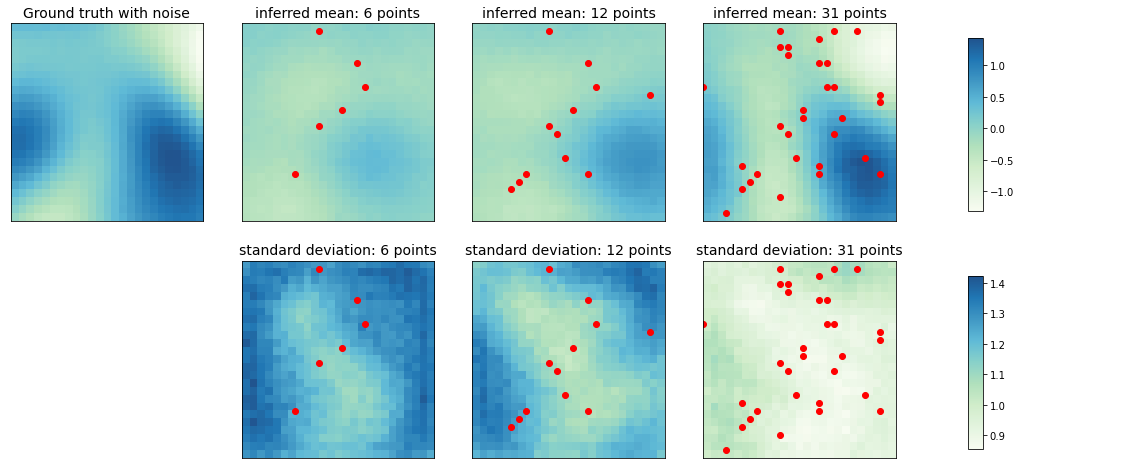

In [35]:
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2+len(mean_post_preds_list), figsize=(20,8))
_min, _max = np.amin(mean_post_preds_list), np.amax(mean_post_preds_list)
al = 0.9
cmap_cols = "GnBu"

# Mean plot
im = axs[0,0].imshow(np.flip(y_observed.reshape(IMAGE_SHAPE), axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], origin='lower', alpha=al, aspect='auto',)
axs[0,0].set_title("Ground truth with noise", fontsize=14)
axs[0,0].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)

for i in range(len(mean_post_preds_list)):
    im = axs[0,i+1].imshow(np.flip(mean_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[0,i+1].set_title("inferred mean: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[0,i+1].axes.xaxis.set_visible(False)
    axs[0,i+1].axes.yaxis.set_visible(False)
    # axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[0,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[0,1+len(mean_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.555, 0.01, 0.30]) # left, bottom, width, height
fig.colorbar(im, ax=axs[0,1+len(mean_post_preds_list)], cax = cbaxes)


# Standard deviation plot
_min, _max = np.amin(sd_post_preds_list), np.amax(sd_post_preds_list)

axs[1,0].axis('off')

for i in range(len(sd_post_preds_list)):
    im = axs[1,i+1].imshow(np.flip(sd_post_preds_list[i].reshape(IMAGE_SHAPE),axis=0), cmap=cmap_cols, interpolation='none', extent=[0,1,0,1], aspect='auto', 
                   origin='lower', vmin= _min, vmax = _max, alpha=al)
    axs[1,i+1].set_title("standard deviation: " + str(num_obs_locations[i]) + " points", fontsize=14)
    axs[1,i+1].axes.xaxis.set_visible(False)
    axs[1,i+1].axes.yaxis.set_visible(False)
    # axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c=obs_ys[i], edgecolors='red')
    axs[1,i+1].scatter(obs_xs[i][:,0], obs_xs[i][:,1], c='red', edgecolors='red')

axs[1,1+len(sd_post_preds_list)].axis('off')
cbaxes = fig.add_axes([0.79, 0.142, 0.01, 0.30])
fig.colorbar(im, ax=axs[1,1+len(sd_post_preds_list)], cax = cbaxes)

# plt.tight_layout()
plt.show()

save_to_dir = FIG_PATH / 'publication'
save_to_dir.mkdir(exist_ok=True)
fig.savefig(save_to_dir / '2DGP_inference_PriorVGAE.jpg', dpi=300, bbox_inches='tight')
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# #plt.savefig('res/2d_n{}_infer_hyperpars.png'.format(n))
# plt.savefig('res/2d_n{}_infer_hyperpars.pdf'.format(n))

mse_vgae = 0.1639798879623413


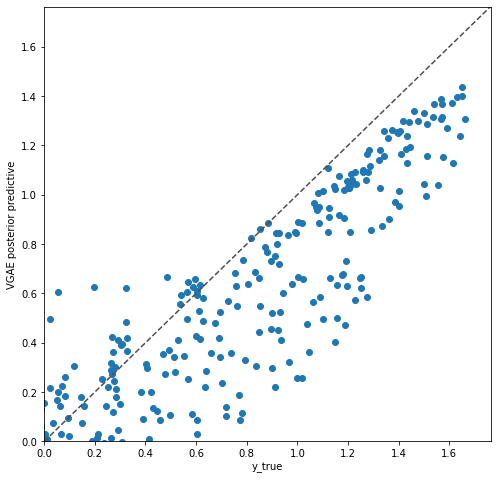

In [36]:
mean_post_pred_vgae = mean_post_preds_list[-1]

plotting.plot_compare_estimates(
    data_x=y_truth.flatten(), data_y=mean_post_pred_vgae,
    x_label='y_true', y_label='VGAE posterior predictive',
    figsize=(8, 8),
)

mse_vgae = np.mean((y_truth.flatten() -  mean_post_pred_vgae)**2)
print(f'mse_vgae = {mse_vgae}')

In [37]:
for idx, mean in enumerate(mean_post_preds_list):
    mse_vgae = np.mean((y_truth.flatten() -  mean)**2)
    print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

mse_vgae (6) = 0.6415140628814697
mse_vgae (12) = 0.5369275808334351
mse_vgae (31) = 0.1639798879623413


In [38]:
for i in range(3): print(jnp.mean(sd_post_preds_list[i]).item())

1.2661950588226318
1.1853082180023193
0.9518858194351196
